## Pancreas dataset - complete pipeline

In [1]:
### load libraries

# standard libraries
import numpy as np
import pandas as pd

# single-cell libraries
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing the parameters of the scVelo figures

# dimension reductions
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
import umap
from scipy.spatial import cKDTree

%load_ext autoreload
%autoreload 2
# import our own functions
import velocity.processing as pp
import velocity.tools as tl
import velocity.visualisation as vis
# to compare runtime
import time
def format_time(t):
  return f"{int(t/3600)}H {int((t/60)%60) if t/3600>0 else int(t/60)}M {int(t%60)}S"

In [3]:
### set arguments for plotting
rcParams["axes.grid"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False

np.random.seed(0)

begin_time = time.time()

## Load original dataset

First, load the pancreas endocrinogenesis dataset. The dataset is made accesible in the scVelo package (version 0.2.4) and can be downloaded using the function `scvelo.datasets.pancreas()`. 

In [9]:
### load pancreas dataset
dataset_path = "../datasets/pancreas/pancreas.h5ad"
adata = ad.read_h5ad(dataset_path)

### convert matrices from sparse to dense
# we only need to do this because of the saving format
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

## Prepare the data

Process the dataset for $\kappa$-velo analysis. Please refer to https://doi.org/10.1101/2022.03.17.484754If to know more about processing. 

- (1) select HVGs, using analytic Pearson residuals (Lause et al., 2021 https://doi.org/10.1186/s13059-021-02451-7).
- (2) filter genes with too low unspliced / spliced counts
- (3) normalise data
- (4) impute u, s counts

#### (1) HVGs

In [11]:
### select HVGs
hvgs = pp.filtering.get_hvgs(adata, no_of_hvgs=5000, theta=100, layer='spliced')
print("Subsetting to top " + str(len(hvgs)) + " highly-variable genes.")
adata = adata[:, hvgs]

Subsetting to top 5000 highly-variable genes.


#### (2) filtering

In [12]:
### subset for genes that have high enough U and S counts
minlim = 4
us_genes = pp.filtering.get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
print("Subsetting to " + str(len(us_genes)) + " genes with sufficient S and U counts.")
adata = adata[:,us_genes]

Subsetting to 406 genes with sufficient S and U counts.


#### (3) normalisation

In [13]:
### L1 normalise unspliced and spliced together with size vector
pp.normalisation.normalise_layers(adata, mode='combined', norm='L1')

total_counts not given


#### (4) imputation

In [14]:
### imputation
pp.imputation.impute_counts(adata, n_neighbours = 30, layer_NN = 'spliced', n_pcs = 15)

## Recover reaction rate parameters

In [15]:
### recover dynamics for all genes
tl.fit.recover_reaction_rate_pars(adata, use_raw=False, n=100, 
                                  fit_kappa=True, fit_scaling=True)

In [16]:
# we save the anndata object before the next filtering steps to make some of the supplementary figure
copy_ = adata.copy()
adata = copy_.copy()

## Filter genes

- (1) Likelihood filtering: After recovery of the reaction rate parameters for all genes, we get the likelihood of the fit. For genes with low likelihoods, the recovered velocities will have a lot of errors. Because of this we exclude these genes
- (2) Prior knowledge filtering: If we know the temporal order of cluster, we can use it as prior knowledge for an additional filtering round if the fitted state assignments do not fit the state assignments from prior knowledge.

#### (1) Likelihood filtering

In [17]:
### remove likelihood genes
likelihood_genes = adata.var['fit_likelihood'].sort_values(ascending=False)
likelihood_genes = likelihood_genes.dropna()
likelihood_genes = likelihood_genes[likelihood_genes >= 0.4]
likelihood_genes = likelihood_genes.index.values

In [18]:
print(str(len(likelihood_genes))+" high-likelihood genes kept")
adata = adata[:, likelihood_genes]

374 high-likelihood genes kept


#### (2) prior knowledge filtering

In [19]:
### set prior state on genes
connections_dict = {'Alpha': ['Pre-endocrine'],
                  'Beta': ['Pre-endocrine'],
                  'Delta': ['Pre-endocrine'],
                  'Epsilon': ['Pre-endocrine'],
                  'Pre-endocrine': ['Ngn3 high EP'],
                  'Ngn3 high EP': ['Ductal'],
                  'Ngn3 high EP': [ 'Ngn3 low EP']
                   }

tl.prior.set_prior_state(adata, connections_dict)

In [20]:
### find all genes where prior state matches the retrieved state
matching_genes = tl.filtering.get_matching_state_genes(adata, perc_match=60)
print(str(len(matching_genes))+" prior state matching genes kept")
adata = adata[:, matching_genes]

134 prior state matching genes kept


### Look at high and low speed genes

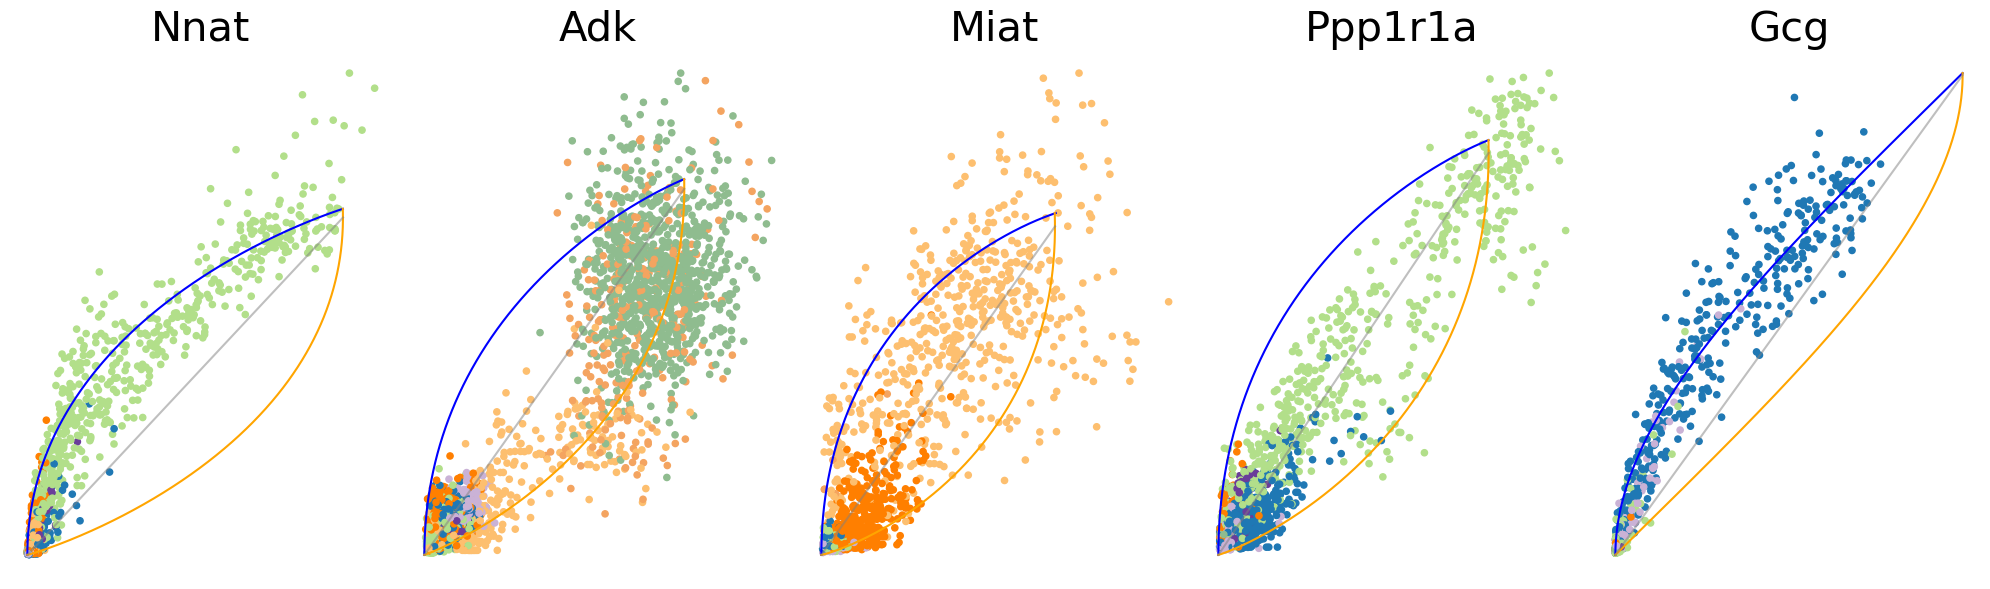

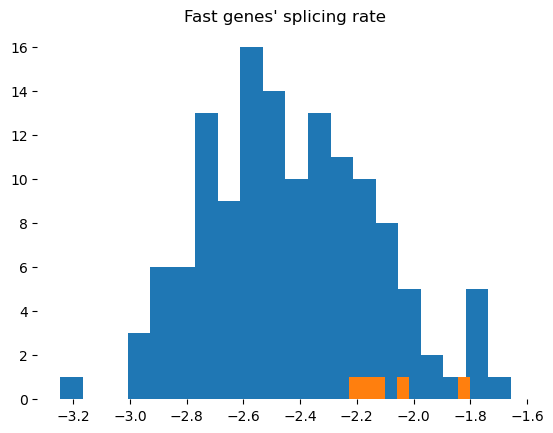

In [23]:
rcParams["axes.spines.left"] = False
rcParams["axes.spines.bottom"] = False

### get colors of each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
cell_colors=adata.obs["clusters"].map(color_dict)

### plot some of the fastest genes
idx = ["Nnat", "Adk", "Miat", "Ppp1r1a", "Gcg"]
tl.fit.plot_kinetics_wrapper(adata, idx, c=cell_colors)

# save figure
save_path = "../figures/Fig4B_pancreas_fast_genes.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()

plt.hist(np.log10(adata.var.fit_beta.astype(float)), bins=20)
plt.hist(np.log10(adata[:,["Nnat", "Adk", "Miat", "Ppp1r1a", "Gcg"]].var.fit_beta.astype(float)))
plt.title("Fast genes' splicing rate")
plt.show()

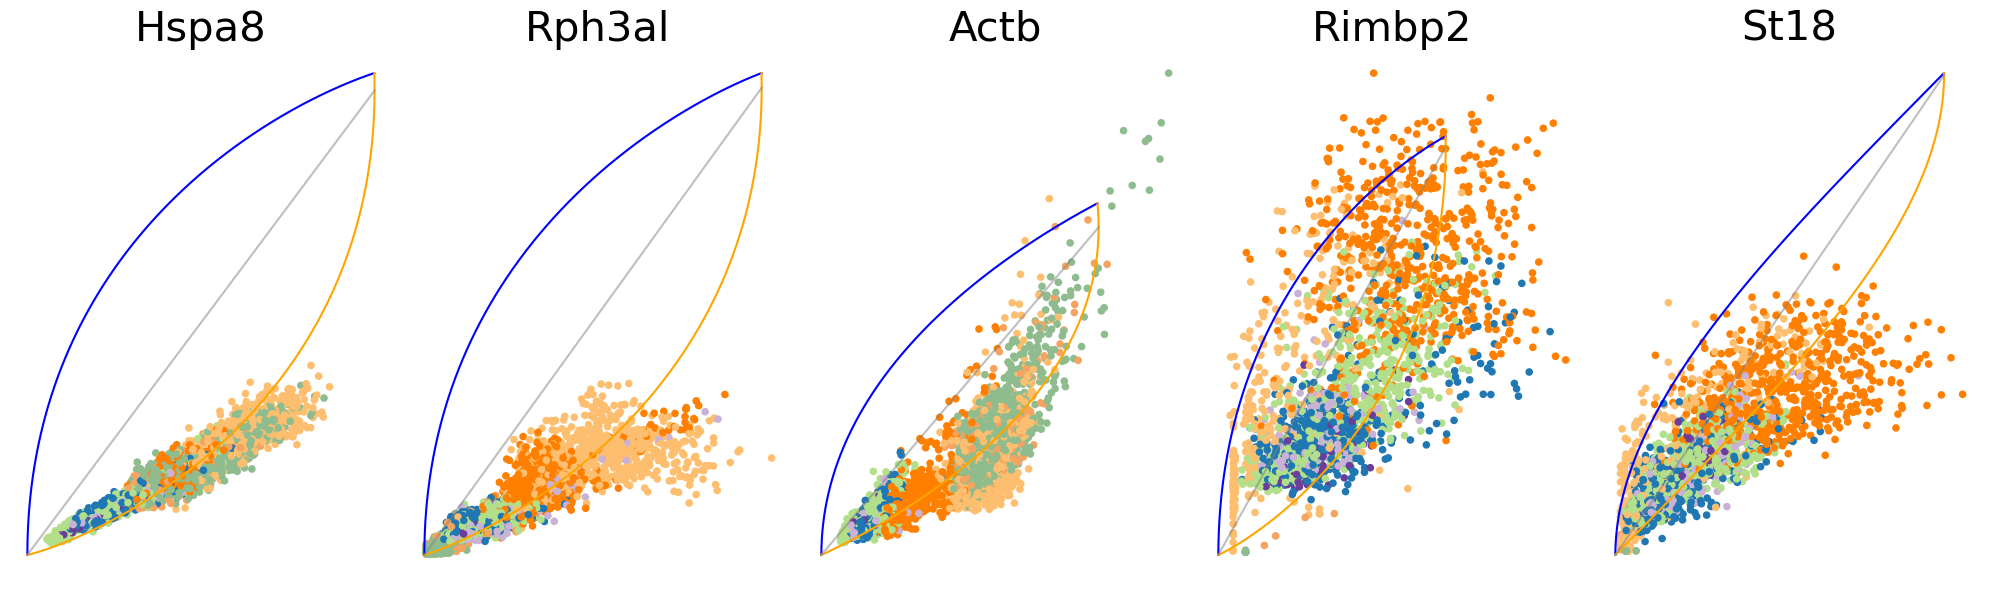

In [24]:
### plot slowest genes
idx = adata[:,adata.var.fit_likelihood>.7].var["fit_beta"].sort_values(ascending=True).index[0:5].tolist()
tl.fit.plot_kinetics_wrapper(adata, idx, c=cell_colors)

# save figure
save_path = "../figures/Fig4B_pancreas_slow_genes.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

## Calculate velocities


In [25]:
### calculate velocity
tl.fit.get_velocity(adata, use_raw=False, key="fit", scale=True)

Trying to set attribute `.layers` of view, copying.


## Plot velocities in low-dimensional embedding

We can visualise the velocities on different types of low dimensional embedding:
- (1) PCA
- (2) UMAP


In [26]:
umap_quiver_kwargs = {"scale": 1, "angles": "xy", "scale_units": "xy", "edgecolors": "k",
                      "linewidth": 0.2,"width": .002,"headwidth": 4,"headaxislength": 4} 
pca_quiver_kwargs = {"scale": 1, "angles": "xy", "scale_units": "xy", "edgecolors": "k",
                     "linewidth": 0.1, "headwidth": 5, "headaxislength": 4}

# settings for pretty plots
from velocity.visualisation.pretty_plotting import *
light_color = np.array([lighten_color(i, .3) for i in cell_colors])

# for less crowded arrows
sub=np.ones(adata.shape[0])
sub[np.arange(0, adata.shape[0], 3)]=0
sub = sub.astype(bool)

#### (1) PCA

In [27]:
### scale data (imputed spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["Ms"])

### run PCA
np.random.seed(0)
n_pcs = 15
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

### create future states
scale = 50
S_fut = adata.layers["Ms"]+(adata.layers["velocity"]*scale)

### scale in the same way as we scaled S
S_fut_scaled = scal.transform(S_fut)

### apply pre-trained PCA transformation on scaled future states
pca_pts_fut = pca.transform(S_fut_scaled)

### get velocity vector in PCA space
pca_v = pca_pts_fut-pca_pts

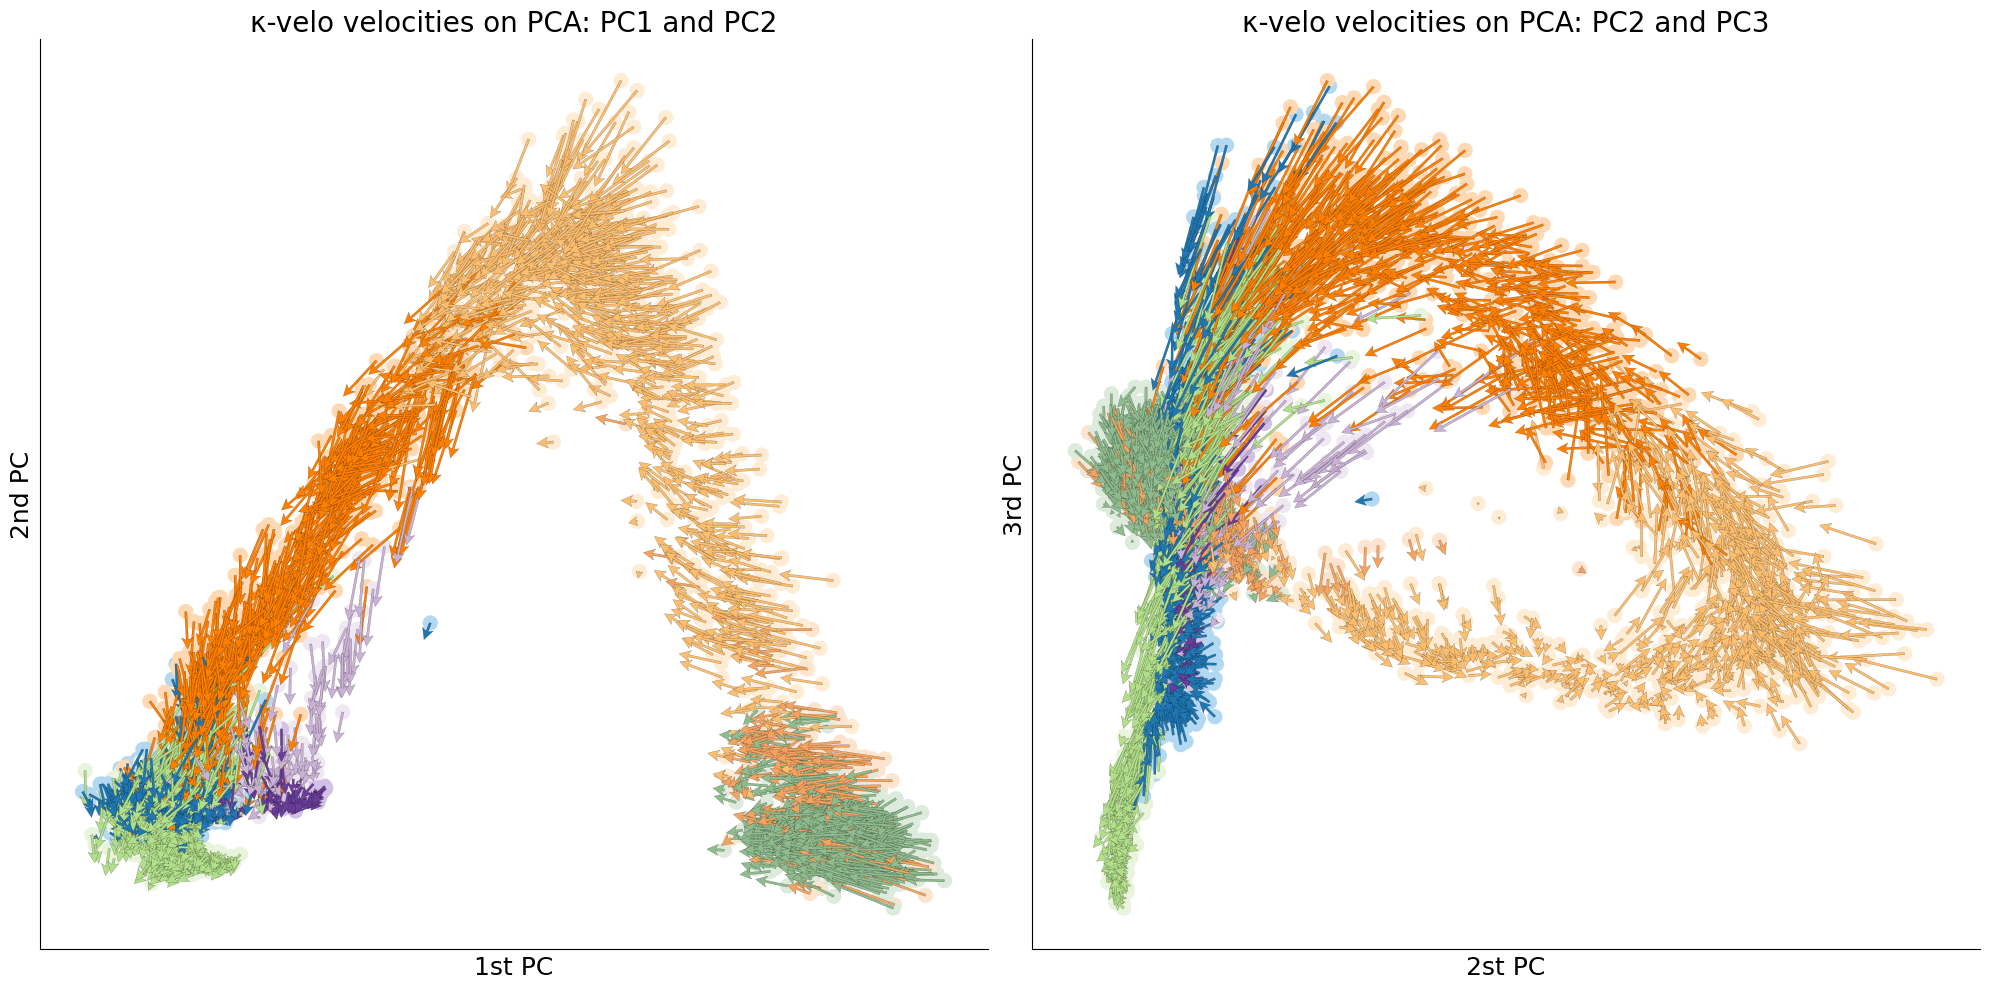

In [28]:
### create PCA plot of pancreas by kappa-velo
rcParams["axes.spines.left"] = True
rcParams["axes.spines.bottom"] = True
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].scatter(pca_pts_fut[:,0], pca_pts_fut[:,1], color="white", s=1)
axs[1].scatter(pca_pts_fut[:,1], pca_pts_fut[:,2], color="white", s=1)
axs[0].scatter(pca_pts[:,0], pca_pts[:,1], color=light_color, s=100)
axs[1].scatter(pca_pts[:,1], pca_pts[:,2], color=light_color, s=100)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

# axis labels
axs[0].set_xlabel("1st PC", fontsize=18)
axs[0].set_ylabel("2nd PC", fontsize=18)
axs[1].set_xlabel("2st PC", fontsize=18)
axs[1].set_ylabel("3rd PC", fontsize=18)

# title
axs[0].set_title("κ-velo velocities on PCA: PC1 and PC2", fontsize=20)
axs[1].set_title("κ-velo velocities on PCA: PC2 and PC3", fontsize=20)

# plot arrows 
axs[0].quiver(pca_pts[:,0], pca_pts[:,1], pca_v[:,0], pca_v[:,1], 
              color=cell_colors, **pca_quiver_kwargs)
axs[1].quiver(pca_pts[:,1], pca_pts[:,2], pca_v[:,1], pca_v[:,2], 
              color=cell_colors, **pca_quiver_kwargs)

plt.tight_layout()
save_path = "../figures/FigS15A_pancreas_PCA.png"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

#### (2) UMAP

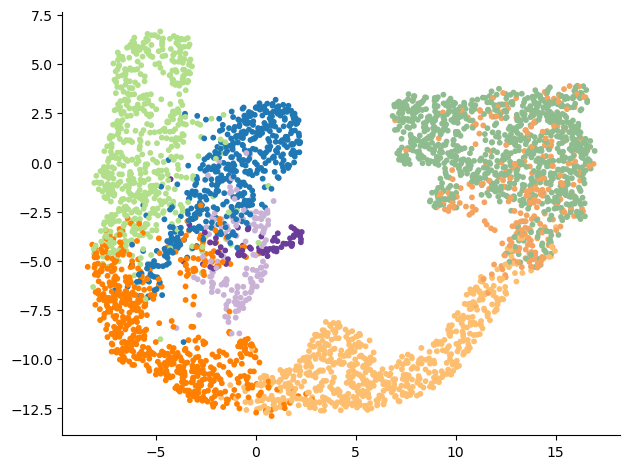

In [29]:
### calculate UMAP 
reducer = umap.UMAP(random_state=2, n_neighbors=210, min_dist=1, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_pts)
UMAP_data[:,1] = -UMAP_data[:,1] # flip bc it is upside down

plt.scatter(UMAP_data[:,0], UMAP_data[:,1], color=cell_colors, s=10)
plt.tight_layout()
plt.show()

In [30]:
### calculate velocity projections
UMAP_fut = vis.vis.nystroem_project(UMAP_data, 
                                    pca_pts, 
                                    pca_pts_fut, 
                                    n_neighbors=50)
UMAP_v = UMAP_fut-UMAP_data
UMAP_v/=(np.std(UMAP_v)*3)

### get top 30 nearest neighbors
NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]

### smoothed velocities
UMAP_v_mean = np.nanmean(np.array(UMAP_v)[NN], axis=1)
UMAP_v_mean/=(np.std(UMAP_v_mean)*3)

Projecting velocities using Nyström approach.


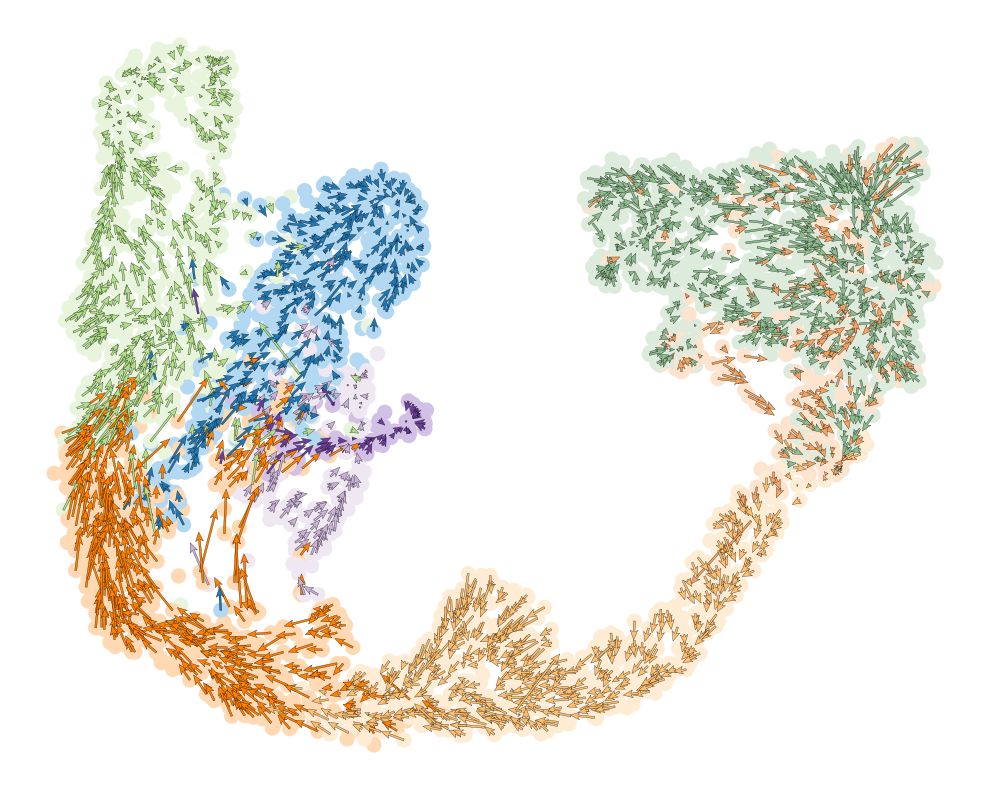

In [31]:
rcParams["axes.spines.left"] = False
rcParams["axes.spines.bottom"] = False

fig, ax = plt.subplots(1, 1, figsize=(10, 8), frameon=False)
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=100)

ax.set_yticks([])
ax.set_xticks([])


# plot arrows 
ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], UMAP_v[sub,0], UMAP_v[sub,1], 
              color=cell_colors[sub], 
              **umap_quiver_kwargs)

plt.tight_layout()
save_path = "../figures/pancreas_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()

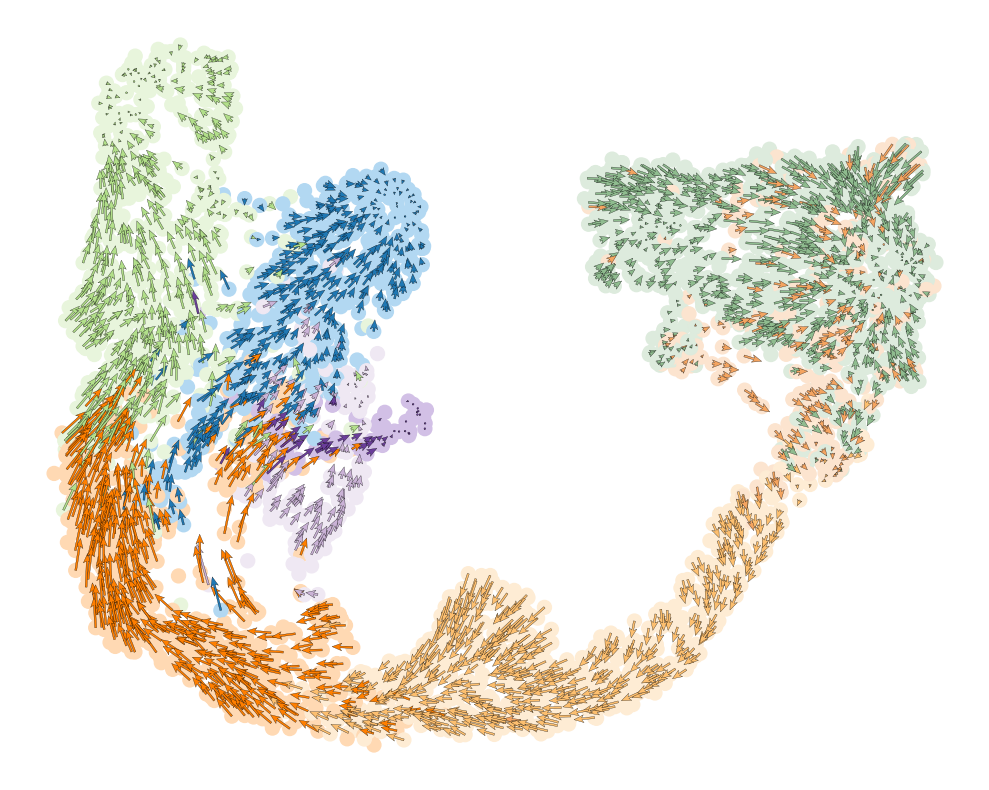

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), frameon=False)
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=100)

ax.set_yticks([])
ax.set_xticks([])

# plot arrows 
ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], UMAP_v_mean[sub,0], UMAP_v_mean[sub,1], 
              color=cell_colors[sub], 
              **umap_quiver_kwargs)

plt.tight_layout()
save_path = "../figures/pancreas_UMAP_smoothed.png"
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()

In [33]:
end_time = time.time()
print(format_time(end_time-begin_time))

0H 37M 25S


In [34]:
# export for comparison with eco-velo
pd.DataFrame(UMAP_data).to_csv("umap_coor.csv")
pd.DataFrame(UMAP_v).to_csv("umap_v.csv")

# scVelo

We compare the results from $\kappa$-velo to scVelo

In [35]:
# run scVelo

import scvelo as scv
begin_time = time.time()

scVelo_data = ad.read_h5ad(dataset_path)

scv.pp.filter_and_normalize(scVelo_data, n_top_genes=5000)
scv.pp.moments(scVelo_data)

scv.tl.recover_dynamics(scVelo_data, n_jobs=8)

scv.tl.velocity_graph(scVelo_data)

Normalized count data: X, spliced, unspliced.
Extracted 5000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/8 cores)


  0%|          | 0/1810 [00:00<?, ?gene/s]

    finished (0:02:55) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity graph
    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


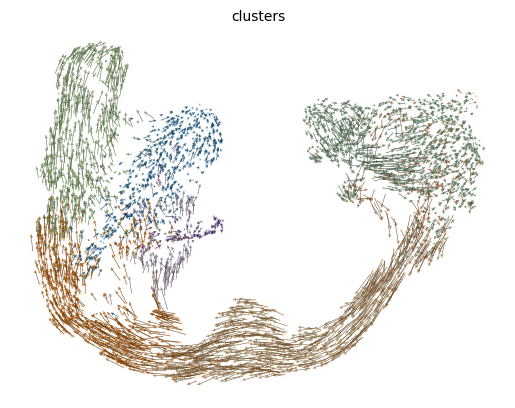

In [36]:
# project on UMAP with scVelo
scv.tl.velocity_graph(scVelo_data)

scVelo_data.obsm["X_umap"]=UMAP_data
scv.pl.velocity_embedding(scVelo_data, basis='umap', scale=.1)

In [37]:
end_time = time.time()
print(format_time(end_time-begin_time))

0H 3M 33S


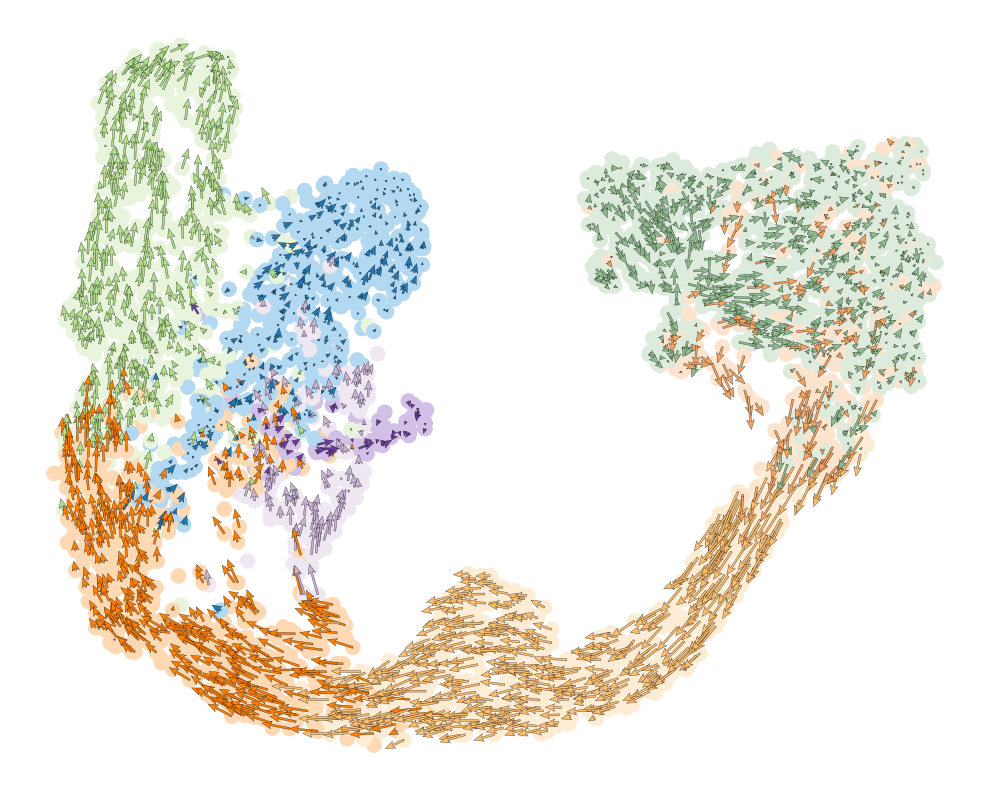

In [38]:
# plotting outside of scVelo so both figures have the same style

scVelo_UMAP_velo = scVelo_data.obsm["velocity_umap"]

scVelo_UMAP_velo/=(np.std(scVelo_UMAP_velo)*3)

### create PCA plot of pancreas by kappa-velo
rcParams["axes.spines.left"] = False
rcParams["axes.spines.bottom"] = False

fig, ax = plt.subplots(1, 1, figsize=(10, 8), frameon=False)
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=100)

ax.set_yticks([])
ax.set_xticks([])
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=100)

# plot arrows 
ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], scVelo_UMAP_velo[sub,0], scVelo_UMAP_velo[sub,1], 
         color=cell_colors[sub], 
          **umap_quiver_kwargs)
plt.tight_layout()

save_path = "../figures/pancreas_UMAP_scVelo_full.png"
plt.savefig(save_path, dpi=300, transparent=True)


plt.show()

In [39]:
### remove genes with no fit for projection on PCA
likelihood_genes = scVelo_data.var['fit_likelihood'].sort_values(ascending=False)
likelihood_genes = likelihood_genes.dropna()
likelihood_genes = likelihood_genes.index.values
scVelo_data = scVelo_data[:, likelihood_genes]

In [40]:
### scale data (imputed spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(scVelo_data.layers["Ms"])

### run PCA
np.random.seed(0)
n_pcs = 15
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

### create future states
scale = .2
S_fut = scVelo_data.layers["Ms"]+(scVelo_data.layers["velocity"]*scale)

### scale in the same way as we scaled S
S_fut_scaled = scal.transform(S_fut)

### apply pre-trained PCA transformation on scaled future states
pca_pts_fut = pca.transform(S_fut_scaled)

### get velocity vector in PCA space
pca_v = pca_pts_fut-pca_pts

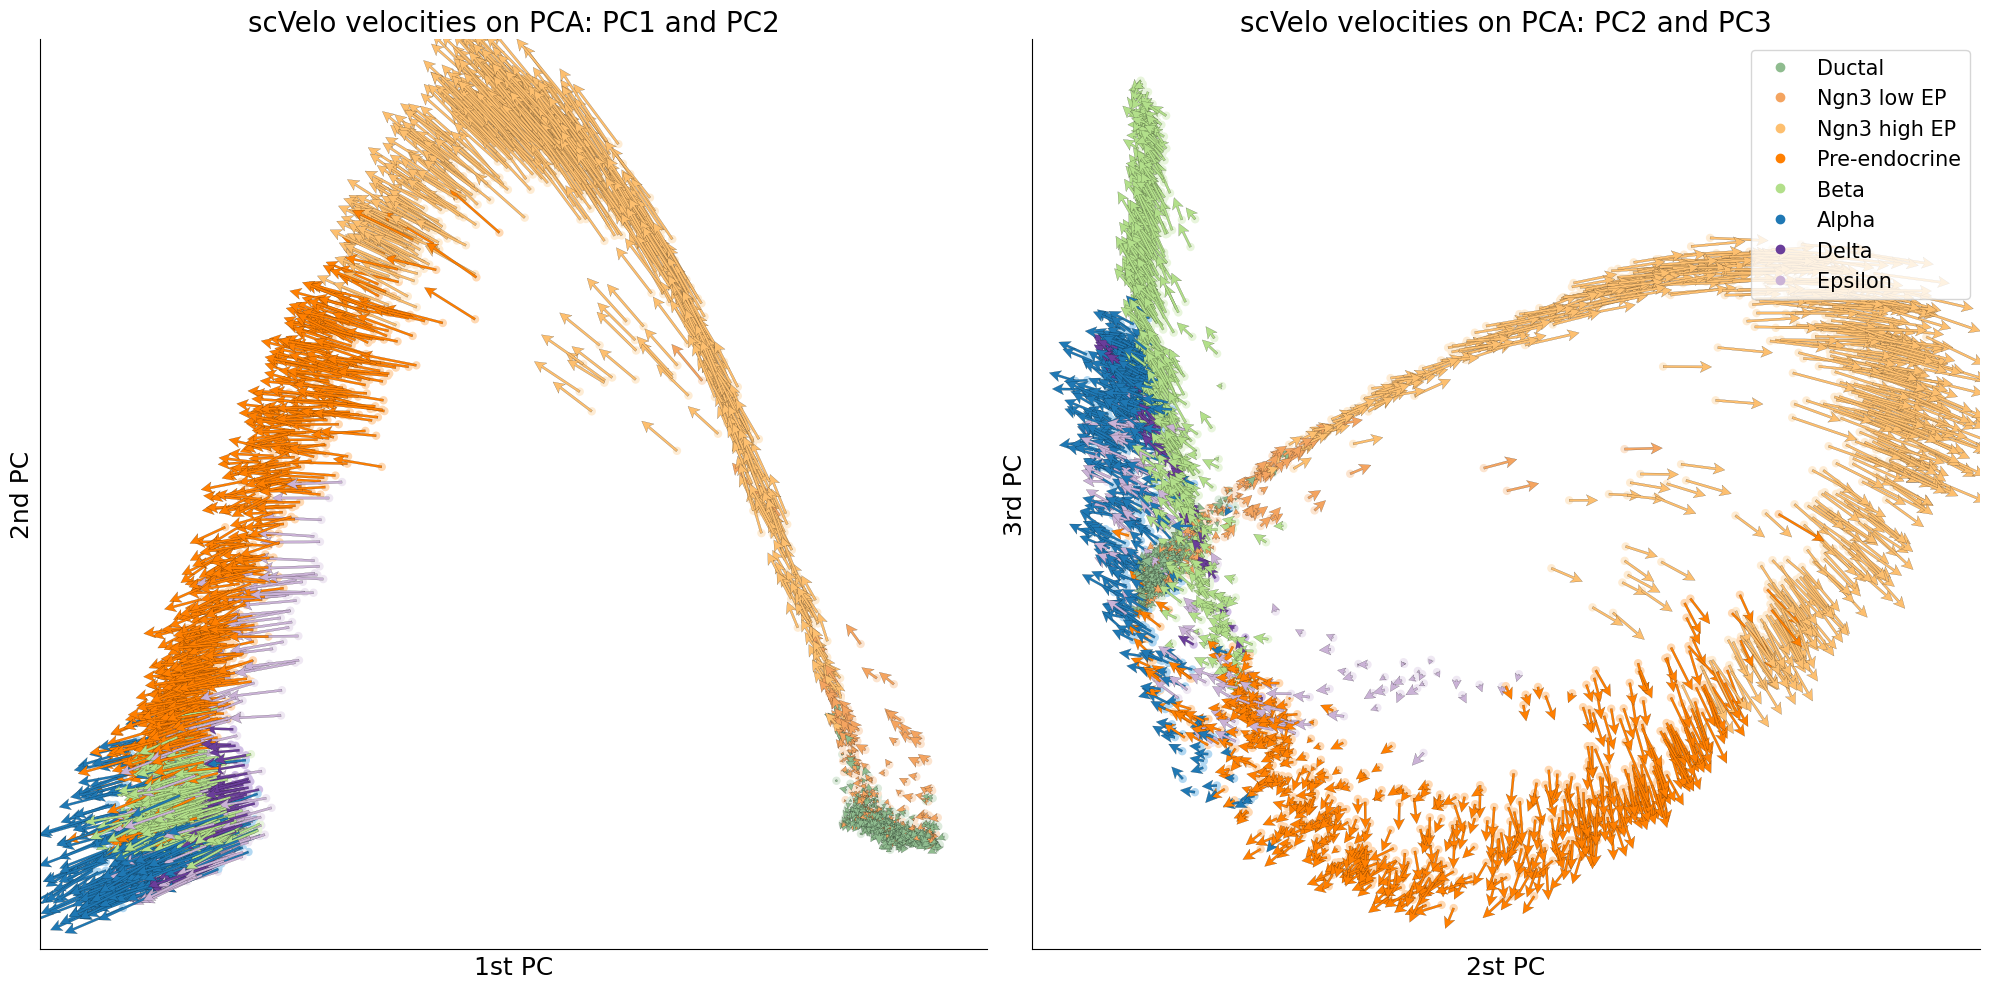

In [41]:
rcParams["axes.spines.left"] = True
rcParams["axes.spines.bottom"] = True

### create PCA plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].scatter(pca_pts[:,0], pca_pts[:,1], color=light_color, s=25)
axs[1].scatter(pca_pts[:,1], pca_pts[:,2], color=light_color, s=25)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

# axis labels
axs[0].set_xlabel("1st PC", fontsize=18)
axs[0].set_ylabel("2nd PC", fontsize=18)
axs[1].set_xlabel("2st PC", fontsize=18)
axs[1].set_ylabel("3rd PC", fontsize=18)

# title
axs[0].set_title("scVelo velocities on PCA: PC1 and PC2", fontsize=20)
axs[1].set_title("scVelo velocities on PCA: PC2 and PC3", fontsize=20)

# plot arrows 
axs[0].quiver(pca_pts[:,0], pca_pts[:,1], pca_v[:,0], pca_v[:,1], 
              color=cell_colors, **pca_quiver_kwargs)
axs[1].quiver(pca_pts[:,1], pca_pts[:,2], pca_v[:,1], pca_v[:,2], 
              color=cell_colors, **pca_quiver_kwargs)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1, loc="upper right", fontsize=15)
plt.tight_layout()
save_path = "../figures/FigS15B_pancreas_scVelo_PCA.png"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

In [42]:
### calculate velocity projections
n_neighbors = 10
UMAP_fut = vis.vis.nystroem_project(UMAP_data, pca_pts, pca_pts_fut, 
                                n_neighbors=n_neighbors,
                                force_no_scale=True)
UMAP_v_scvelo = UMAP_fut-UMAP_data

### get top 30 nearest neighbors
NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]

### smoothed velocities
UMAP_v_mean = np.nanmean(np.array(UMAP_v_scvelo)[NN], axis=1)

Projecting velocities using Nyström approach.


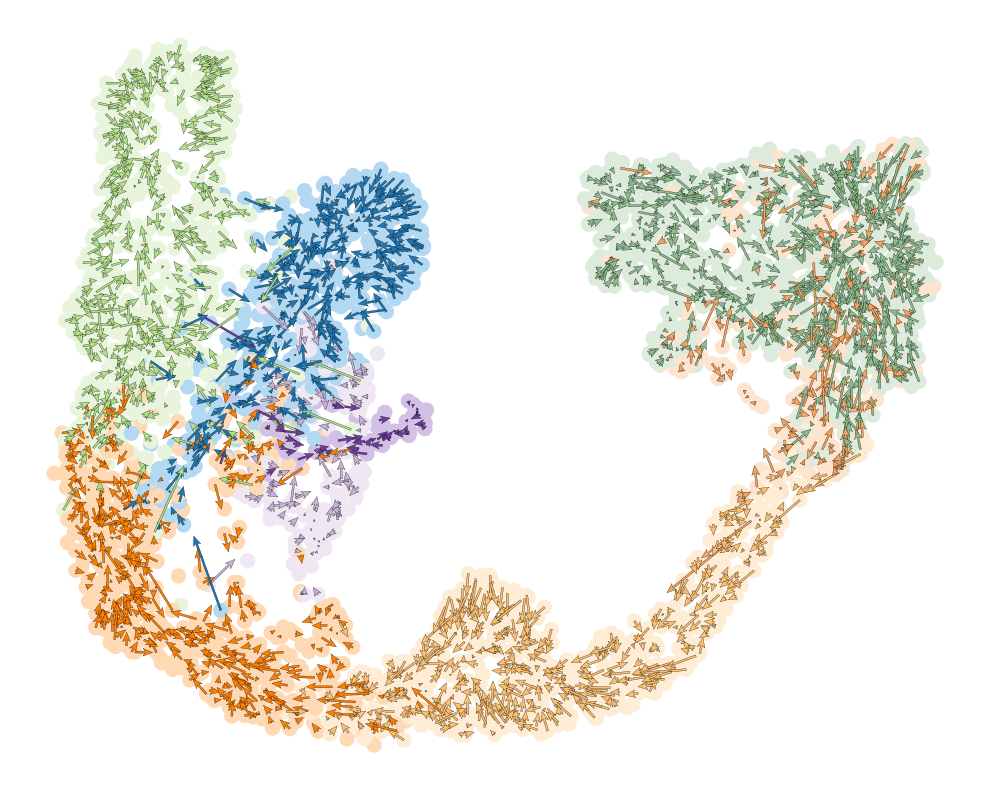

In [43]:
rcParams["axes.spines.left"] = False
rcParams["axes.spines.bottom"] = False

UMAP_v_scvelo/=(np.std(UMAP_v_scvelo)*3)


fig, ax = plt.subplots(1, 1, figsize=(10, 8), frameon=False)
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=100)

ax.set_yticks([])
ax.set_xticks([])

# plot arrows 
ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], UMAP_v_scvelo[sub,0], UMAP_v_scvelo[sub,1], 
              color=cell_colors[sub], 
              **umap_quiver_kwargs)

plt.tight_layout()
save_path = "../figures/pancreas_UMAP_scVelo.png"
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()

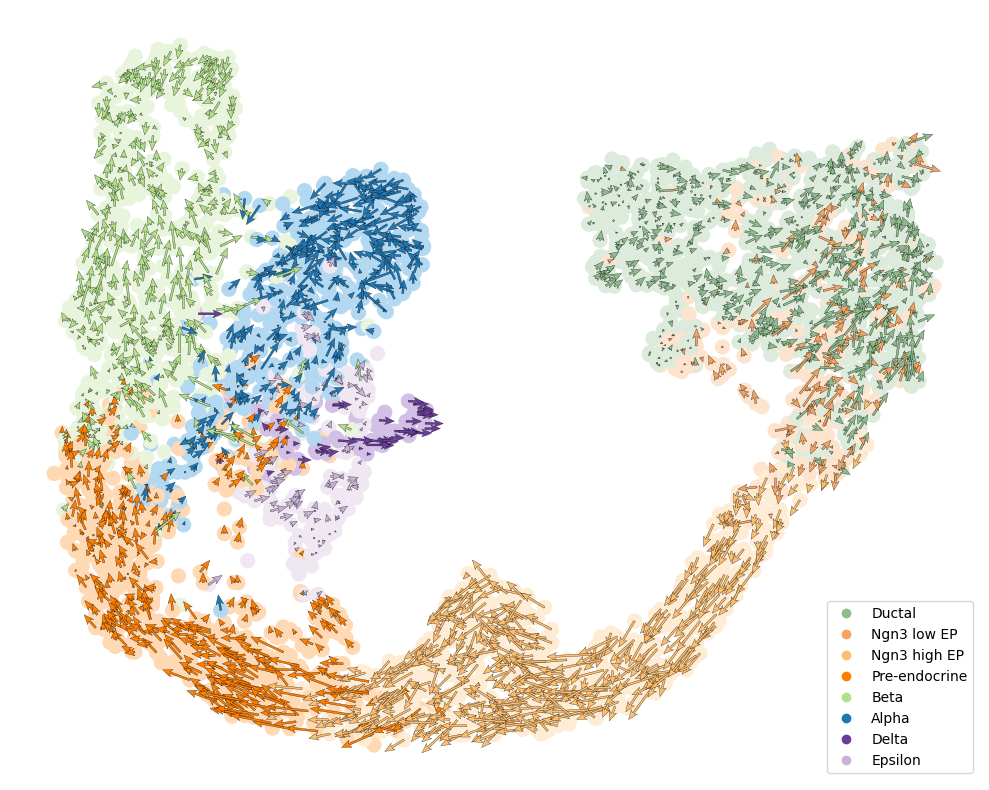

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), frameon=False)
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=100)

ax.set_yticks([])
ax.set_xticks([])

# plot arrows 
UMAP_v_mean/=(np.std(UMAP_v_mean)*3)

ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], UMAP_v_mean[sub,0], UMAP_v_mean[sub,1], 
              color=cell_colors[sub], 
              **umap_quiver_kwargs)

plt.tight_layout()
save_path = "../figures/pancreas_UMAP_scVelo_smoothed.png"
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1, loc="lower right", fontsize=10)
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()

In [45]:
# compare parameters

### unscaled parameters
alpha = scVelo_data.var["fit_alpha"]/np.nanmedian(scVelo_data.var["fit_alpha"])
beta = scVelo_data.var["fit_beta"]/np.nanmedian(scVelo_data.var["fit_beta"])
gamma = scVelo_data.var["fit_gamma"]/np.nanmedian(scVelo_data.var["fit_gamma"])

### scaled parameters
new_alpha = scaled_data.var["fit_alpha"].astype(float)/np.nanmedian(scaled_data.var["fit_alpha"].astype(float))
new_beta = scaled_data.var["fit_beta"].astype(float)/np.nanmedian(scaled_data.var["fit_beta"].astype(float))
new_gamma = scaled_data.var["fit_gamma"].astype(float)/np.nanmedian(scaled_data.var["fit_gamma"].astype(float))

### plot the recovered parameters for original protocol (scVelo) and kappa-velo
rcParams["axes.spines.left"] = True
rcParams["axes.spines.bottom"] = True
fig, axs = plt.subplots(1, 3, figsize=(9,3), frameon=False, sharey=False)

_, bins, _ = axs[0].hist(np.log10(alpha), bins=20, alpha=.6, color="tab:red", label=["scVelo"], density=True)
axs[0].hist(np.log10(new_alpha), bins=bins, alpha = .6, color="royalblue", label=["κ-velo"], density=True)
l = np.max(np.log10(alpha))
axs[0].set_xlim((-l, l))

_, bins, _ = axs[1].hist(np.log10(beta), bins=20, alpha=.6, color="tab:red", density=True)
axs[1].hist(np.log10(new_beta), bins=bins, alpha = .6, color="royalblue", density=True)
l = np.max(np.log10(beta))
axs[0].set_xlim((-l, l))

_, bins, _ = axs[2].hist(np.log10(gamma), bins=20, alpha=.6, color="tab:red", density=True)
axs[2].hist(np.log10(new_gamma), bins=bins, alpha = .6, color="royalblue", density=True)
l = np.max(np.log10(gamma))
axs[2].set_xlim((-l, l))

pars = ["alpha", "beta", "gamma"]
title = ["Transcription rate\n", "Splicing rate\n", "Degradation rate\n"]
for i in range(3):
    axs[i].grid(False)
    axs[i].set_xticks([-2, -1, 0, 1, 2])
    axs[i].set_yticks([0,.5, 1, 1.5])
    axs[i].set_ylim([0, 1.5])
    axs[i].set_ylabel("Frequency", fontsize=14)
    axs[i].set_xlabel("log10" +pars[i], fontsize=14)
    axs[i].set_title(title[i], fontsize=18)
    
axs[0].legend(fontsize=12, loc='upper left')

plt.tight_layout()

# save figure
save_path = "../figures/FigS14_recovered_parameters_pancreas.pdf"
plt.savefig(save_path, dpi=200, transparent=True)

plt.show()

NameError: name 'scaled_data' is not defined

In [ ]:

rcParams["axes.spines.left"] = True
rcParams["axes.spines.bottom"] = True
rcParams["axes.spines.right"] = True
rcParams["axes.spines.top"] = True

fig, ax = plt.subplots(1, 1, figsize=(3,7), frameon=False, sharey=False)


_, bins, _ = ax.hist(np.log10(beta), bins=20, alpha=.6, color="tab:red", density=True)
ax.hist(np.log10(new_beta), bins=bins, alpha = .6, color="royalblue", density=True)
l = np.max(np.abs(np.log10(beta)))
ax.set_xlim((-l, l))


ax.grid(False)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([0,.5, 1, 1.5])
ax.set_ylim((0, 1.8))
ax.set_ylabel("")
ax.set_xlabel("")
    

plt.tight_layout()

# save figure
save_path = "../figures/recovered_parameters_pancreas_beta.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False

# Supplementary figures

#### (1) quantitative comparison scVelo / $\kappa$-velo

In [ ]:
v_us, v_scvelo = UMAP_v, scVelo_UMAP_velo
v_us /= np.std(v_us)
v_scvelo /= np.std(v_scvelo)

In [ ]:
from velocity.visualisation.vis_utils import vector_distance
### calculate change in direction
a0= vector_distance(v_us, v_scvelo, metric="cosine")
### calculate change in angle
d0 = vector_distance(v_us, v_scvelo, metric="norm_diff")
n0 = vector_distance(v_us, v_scvelo, metric="diff_norm")

In [ ]:
rcParams["axes.spines.left"] = False
rcParams["axes.spines.bottom"] = False

# cell type umap
fig, axs = plt.subplots(1,1, figsize=(5, 4.5), frameon=False)
im = axs.scatter(UMAP_data[:,0], UMAP_data[:,1], s=15, color=cell_colors, alpha=1)
axs.set_title("Cell types", fontsize=16)
axs.set_yticks([]), axs.set_xticks([])
plt.tight_layout()
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1, loc="lower right", fontsize=7)
plt.savefig("../figures/fig_cell_type_pancreas", dpi=300, transparent=True)

# distance metric umap
titles = ["", "Diff. in vector norm", ""]
color = [a0, d0, n0]
cmaps = ["YlOrRd_r", "bwr", "YlOrRd"]
vmin_vmax = [(-1, 1), (-2, 2), (0, 3)]
save_name = ["fig_cosine_pancreas", "fig_norm_pancreas", "fig_errors_pancreas"]
for i in range(3):
    fig, axs = plt.subplots(1,1, figsize=(5, 4.5), frameon=False)
    vmin, vmax=vmin_vmax[i]
    im = axs.scatter(UMAP_data[:,0], UMAP_data[:,1], s=15, c=color[i], alpha=.5, vmin=vmin, vmax=vmax, cmap=cmaps[i])
    cax = fig.add_axes([0.52, 0.88, 0.4, 0.05])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=15)
    axs.set_title(titles[i], fontsize=16)
    axs.set_yticks([]), axs.set_xticks([])
    plt.tight_layout()
    plt.savefig("../figures/"+save_name[i], dpi=300, transparent=True)

plt.show()

#### (2) kappa from S

In [ ]:
from velocity.tools.fit_utils import *
from velocity.tools.kappa import *

In [ ]:
adata = copy_.copy()

In [ ]:
### get kappa and scale anndata object
beta_s = np.ones(adata.shape[1])
beta_u = adata.var.fit_beta

alpha, gamma, Uk = adata.var.fit_alpha, adata.var.fit_gamma, adata.var.fit_U_switch
scaling = adata.var.fit_scaling
Pi = adata.layers["fit_Pi"]
unspliced, spliced = adata.layers["Mu"], adata.layers["Ms"]
for i in range(scaled_data.shape[1]):
    if np.isnan(beta_u[i]):
        beta_s[i] = np.nan
    else:
        k = (unspliced[:,i] * scaling[i]) > (gamma[i]/beta_u[i] * spliced[:,i])
        st = S(alpha[i]/beta_u[i], gamma[i]/beta_u[i], 0, 0, Pi[:,i])
        beta_s[i] = get_kappa(alpha=alpha[i]/beta_u[i], beta=1, gamma=gamma[i]/beta_u[i], 
                              ut=Pi[:,i], st=st, u_switch=Uk[i], k=k, mode="s")




In [ ]:
from scipy.stats import pearsonr

rcParams["axes.spines.left"] = True
rcParams["axes.spines.bottom"] = True

fig, axs = plt.subplots(1, 1, figsize=(5,5), frameon=False)
x, y = np.log(beta_s.astype(float)*100), np.log(beta_u.astype(float)*100)
sub = (~np.isnan(y))&(~np.isnan(x))&(x!=-np.infty)
x, y = x[sub], y[sub]
plt.scatter(x, y, c="black")
axs.text(-3.5, 3.3, 
         "Person's corr: "+str(np.round(pearsonr(x, y)[0],2)),
        bbox={'facecolor': 'white', 'pad': 10})
axs.set_xlim((-4, 4))
axs.set_ylim((-4, 4))
axs.plot([-4, 4], [-4, 4])
plt.xlabel("log kappa from s(t)")
plt.ylabel("log kappa from u(t)")
#plt.savefig("../figures/SXX_pancreas_kappa_from_st.png", dpi=300, transparent=True)
plt.show()